In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score

In [33]:
df_train  = pd.read_csv('./input/train.csv')
df_test = pd.read_csv('./input/test.csv')

In [34]:
df_train['Type'] = 'Train'
df_test['Type'] = 'Test'
df_all = pd.concat([df_train, df_test], axis=0)

### EDA

In [35]:
df_all.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Type
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,Train
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,Train
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,Train
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,Train
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,Train


In [36]:
df_all.shape

(1309, 13)

In [37]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 13 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
Type           1309 non-null object
dtypes: float64(3), int64(4), object(6)
memory usage: 143.2+ KB


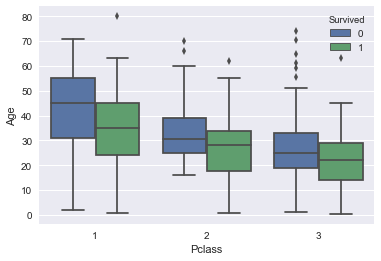

In [38]:
sns.boxplot(x = 'Pclass', y= 'Age', hue= 'Survived', data = df_train[df_train['Type'] == 'Train'])

In [10]:
df_train[['Age','Pclass','Survived']].groupby(['Pclass','Survived']).mean()

Age
Pclass Survived           
1      0         43.695312
       1         35.368197
2      0         33.544444
       1         25.901566
3      0         26.555556
       1         20.646118

In [39]:
df_all.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Type
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,Train
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,Train
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,Train
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,Train
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,Train


C:\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


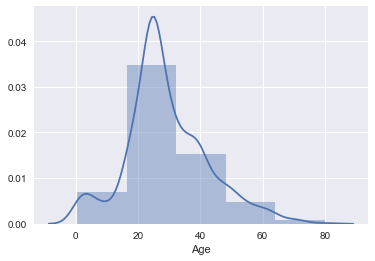

In [110]:
sns.distplot(df_all[df_all['Type'] == 'Train']['Age'], 5)

### Feature Engineering

In [40]:
import re
def findtitle(str_name):
    m = re.search(r', (?P<Title>.*?)\.',str_name)
    return m.group('Title')

In [41]:
df_all['Title'] = df_all['Name'].apply(findtitle)

In [42]:
a,b = np.unique(df_all['Title'], return_counts=True)
for x,y in zip(a,b):
    print(x, y)

Capt 1
Col 4
Don 1
Dona 1
Dr 8
Jonkheer 1
Lady 1
Major 2
Master 61
Miss 260
Mlle 2
Mme 1
Mr 757
Mrs 197
Ms 2
Rev 8
Sir 1
the Countess 1


In [60]:
list(df_all['Title'].unique())

['Mr',
 'Mrs',
 'Miss',
 'Master',
 'Don',
 'Rev',
 'Dr',
 'Mme',
 'Ms',
 'Major',
 'Lady',
 'Sir',
 'Mlle',
 'Col',
 'Capt',
 'the Countess',
 'Jonkheer',
 'Dona']

In [65]:
l_rare = [title for title in list(df_all['Title'].unique()) if  title not in ['Master','Miss','Mr','Mrs']]
df_all['Title1'] = df_all['Title'].replace(to_replace = l_rare
                          ,value = 'Rare')

In [66]:
df_all['Title1'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Rare'], dtype=object)

In [74]:
def imputeData(df):
    df['Age'] = df.groupby(['Pclass']) \
                  .transform(lambda x: x.fillna(x.mean()))
        
    df['Embarked'] = df.groupby(['Pclass'])['Embarked'] \
                      .transform(lambda x : x.fillna(x.value_counts().index[0]))
    return df

def prepData(df):
    df['Pclass'] =  df['Pclass'].astype(object)
    df['CabinNA'] = df['Cabin'].isnull().astype(object)
    df_dummies = pd.get_dummies(df[['Sex','Pclass','Embarked','CabinNA','Title1']])
    df1 = df.join(df_dummies)
    df_x = df1.drop(['PassengerId','Pclass','Cabin','Embarked','CabinNA','Name','Sex',
                     'Ticket','Fare','Sex_male','Pclass_3','Embarked_S','CabinNA_True','Title','Title1','Title1_Rare','Type']
               , axis = 1)
    arr_x, col_x = df_x.values, df_x.columns
    return arr_x, col_x

In [79]:
df = imputeData(df_all);
x_train, col_train = prepData(df[df['Type'] == 'Train'].drop(['Survived'], axis=1));
y_train = df[df['Type'] == 'Train']['Survived']
x_test, col_test = prepData(df[df['Type'] == 'Test'].drop(['Survived'], axis=1));

In [81]:
x_data.shape

(891, 13)

In [ ]:
reg = LogisticRegression()

In [85]:
from sklearn.metrics import log_loss, make_scorer
logloss_scorer = make_scorer(log_loss)

In [88]:
loss = cross_val_score(reg,x_train,y_train,cv= 5, scoring = logloss_scorer)
np.mean(loss)

5.73562226721298

### Finding Learning Curve

In [90]:
from sklearn.model_selection import learning_curve

In [102]:
reg = LogisticRegression()
train_sizes, train_scores, valid_scores = learning_curve(reg,x_train,y_train,train_sizes=[.2,.4,.6,.8,1], 
                                                         cv=5, scoring = logloss_scorer)

In [103]:
np.mean(train_scores,axis=1)

array([ 3.62834821,  5.23319721,  5.67925005,  5.4810189 ,  5.50402325])

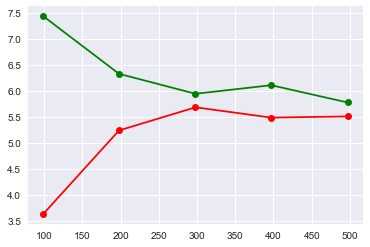

In [104]:
plt.plot(train_sizes, np.mean(train_scores,axis=1), 'o-', color ='red')
plt.plot(train_sizes, np.mean(valid_scores,axis=1), 'o-', color ='green')

In [83]:
scores = cross_val_score(reg,x_train,y_train,cv=5,scoring = 'f1_macro')
print("F1: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

F1: 0.82 (+/- 0.04)


In [77]:
y_pred = reg.predict(x_test)

In [108]:
result = pd.DataFrame({'PassengerId': df_test['PassengerId'], 'Survived': y_pred.astype(int)})
result.to_csv('submission_190103_v3.csv', index=False)